# Exercise 1 

Consider the `insurance.csv`. This file contains information related customers' demographis and insurance premium. The goal is to build models to predict insurance premiums. Define the input (all variables but `charges`) and target variables. 0-1 encode the categorical features using `get_dummies`.

### Exercise 1(a) (3 points)

Create a `.py` file that reads the data and splits it into `train` (80%) and `test` (20%). Save both data-frames as `train.csv` and `test.csv`, respectively.

### Exercise 1(b) (15 points)

Create a `.py` file that reads the `train.csv` data file, tunes (using `Optuna`) and log the best `RandomForestRegressor` model out-of-sample performance (using `root_mean_squared_error`) over 5-folds in `mlflow`. Then, run the `permutation_importance` algorithm and identify the top five features. After that, re-run `Optuna` with the top five features and log the model performance.

### Exercise 1(c) (15 points)

Create a `.py` file that reads the `train.csv` data file, tunes (using `Optuna`) and log the best `ExtraTreesRegressor` model out-of-sample performance (using `root_mean_squared_error`) over 5-folds in `mlflow`. Then, run the `permutation_importance` algorithm and identify the top five features. After that, re-run `Optuna` with the top five features and log the model performance.

### Exercise 1(d) (15 points)

Create a `.py` file that reads the `train.csv` data file, tunes (using `Optuna`) and log the best `GradientBoostingRegressor` model out-of-sample performance (using `root_mean_squared_error`) over 5-folds in `mlflow`. Then, run the `permutation_importance` algorithm and identify the top five features. After that, re-run `Optuna` with the top five features and log the model performance.

### Exercise 1(e) (15 points)

Create a `.py` file that reads the `train.csv` data file, tunes (using `Optuna`) and log the best `XGBRegressor` model out-of-sample performance (using `root_mean_squared_error`) over 5-folds in `mlflow`. Then, run the `permutation_importance` algorithm and identify the top five features. After that, re-run `Optuna` with the top five features and log the model performance.

### Exercise 1(f) (5 points)

Create a shell file that runs the scripts from parts 1(b) to 1(e).

### Exercise 1(g) (7 points)

Create a `.py` file that reads the `test.csv` data file. Load the best models from sections 1(b) to 1(e) to make predictions on the `test` dataset, and report their corresponding root mean squared errors (RMSE). Additionally, report the RMSE of the average ensemble of the models from sections 1(b) to 1(e).



[I 2025-02-26 18:57:45,104] A new study created in memory with name: no-name-d0f23807-5089-471e-985f-5485c6366452
[I 2025-02-26 18:57:45,380] Trial 0 finished with value: 4802.437046039103 and parameters: {'n_estimators': 104, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 4802.437046039103.
[I 2025-02-26 18:57:45,418] Trial 2 finished with value: 4559.181044752331 and parameters: {'n_estimators': 149, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'random_state': 42, 'n_jobs': -1}. Best is trial 2 with value: 4559.181044752331.
[I 2025-02-26 18:57:45,510] Trial 6 finished with value: 4541.654665224506 and parameters: {'n_estimators': 177, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 42, 'n_jobs': -1}. Best is trial 6 with value: 4541.654665224506.
[I 2025-02-26 18:57:45,530] Trial 5 finished with value: 4543.017627811538 and parameters: {'n_estimators': 232

<Figure size 864x576 with 0 Axes>

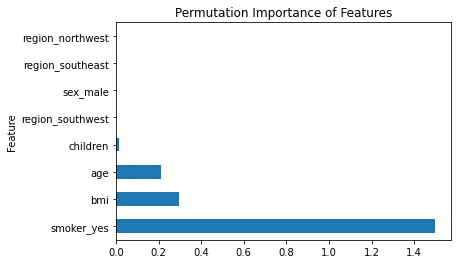

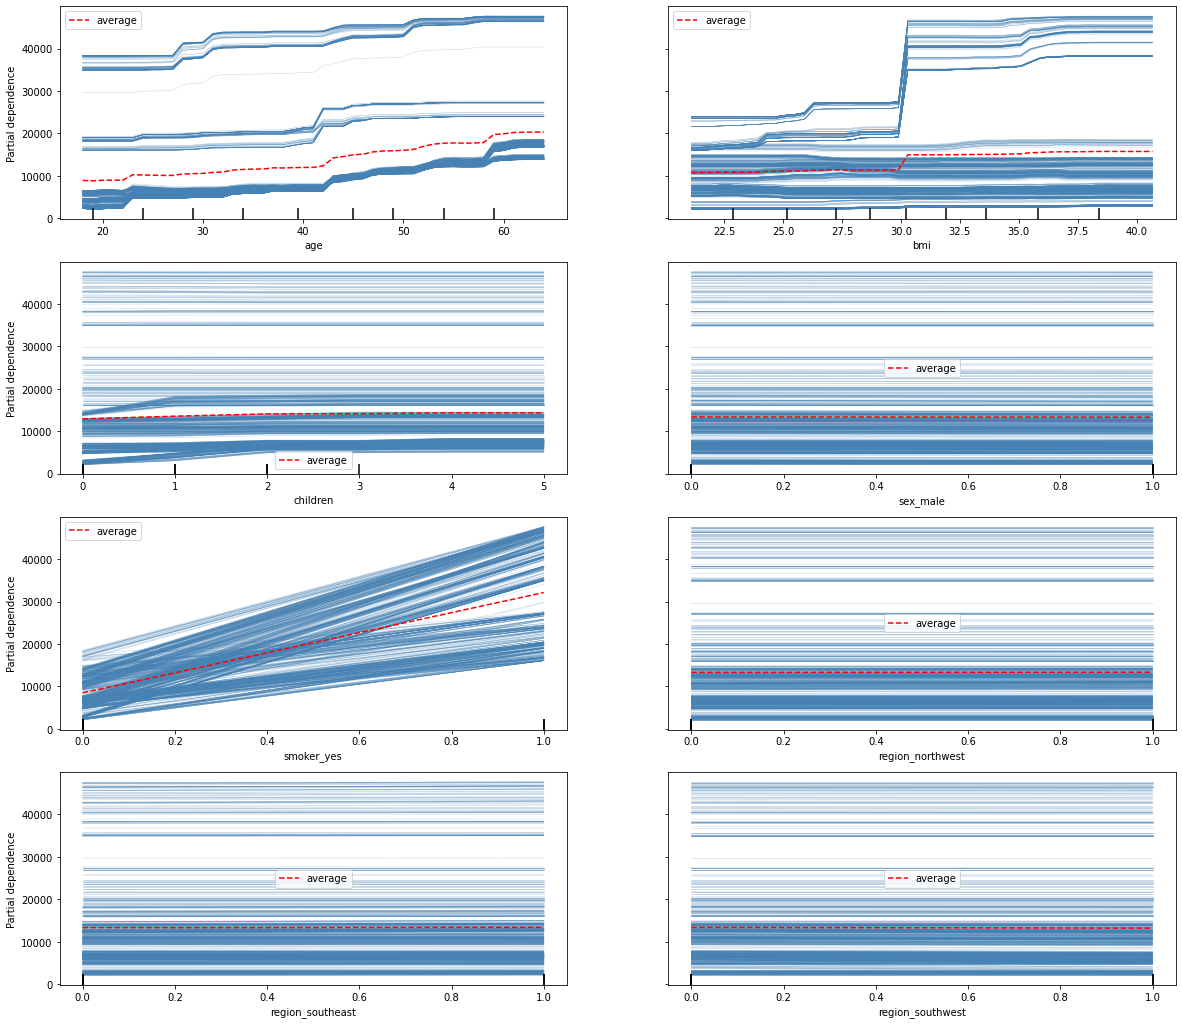

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor

import optuna

# Load the data
df = pd.read_csv("train.csv")

# Define the features and target
X = df.drop(columns=["charges"])
y = df["charges"]

# Define the cross-validation
skf = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the objective function
def objective(trial, X, y):

    # Define the hyperparameters
    params = dict(n_estimators=trial.suggest_int("n_estimators", 100, 300),
                  max_depth=trial.suggest_int("max_depth", 5, 10),
                  min_samples_split=trial.suggest_int(
                      "min_samples_split", 2, 10
                  ),
                  min_samples_leaf=trial.suggest_int(
                      "min_samples_leaf", 1, 10
                  ),
                  random_state=trial.suggest_categorical("random_state", [42]),
                  n_jobs=trial.suggest_categorical("n_jobs", [-1]))

    # Define the model
    model = RandomForestRegressor(**params)

    # Compute the cross-validation score
    score = -1 * cross_val_score(
        model,
        X,
        y,
        cv=skf,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    ).mean()

    return score


# Store the optimization results
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X, y), n_trials=50, n_jobs=-1)
RF_params = study.best_params
RF_RMSE = study.best_value

# Setting the MLflow experiment
# mlflow.set_experiment("In_Class_6_Oscar")
# mlflow.sklearn.autolog()


# Perform the permutation importance and visualize the results
def plot_perm_imp_depen(X, y, model):

    # Train the model
    model_fit = model.fit(X, y)

    # Compute the permutation importance
    permutation_scores = permutation_importance(
        model_fit, X, y, n_repeats=20, random_state=42, n_jobs=-1
    )

    # Create a DataFrame for visualization
    feature_importances = pd.DataFrame(
        {
            "Feature": X.columns,
            "Importance": permutation_scores.importances_mean,
        }
    )

    # Sort the DataFrame by importance
    feature_importances = feature_importances.sort_values(
        by="Importance", ascending=False
    )

    # Plot the feature importances
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    feature_importances.plot(
        x="Feature",
        y="Importance",
        kind="barh",
        title="Permutation Importance of Features",
        legend=False,
    )
    plt.savefig("RF_importances.png")
    plt.show()

    # Plot the partial dependence plots
    fig, ax1 = plt.subplots(4, 2, figsize=(20, 18))
    fig.suptitle("Random Forest Partial Dependence Plots", fontsize=20)
    PartialDependenceDisplay.from_estimator(
        model_fit,
        X,
        features=X.columns.to_list(),
        kind = 'both',
        pd_line_kw = {"color": "red"},
        ice_lines_kw = {"color": "steelblue"},
        n_jobs=-1,
        grid_resolution=50,
        ax=ax1,
    )
    plt.savefig("RF_partial_dependence.png")
    plt.show();

# Running the permutation importance
plot_perm_imp_depen(X, y, RandomForestRegressor(**RF_params))